In [1]:
%pylab inline
from serial.tools.list_ports import comports
import serial

Populating the interactive namespace from numpy and matplotlib


In [2]:
[j for j in comports()]

[('COM3',
  'Intel(R) Active Management Technology - SOL (COM3)',
  'PCI\\VEN_8086&DEV_A13D&SUBSYS_06B91028&REV_31\\3&11583659&0&B3'),
 ('COM1', 'Communications Port (COM1)', 'ACPI\\PNP0501\\0'),
 ('COM5', 'USB Serial Device (COM5)', 'USB VID:PID=2184:0006 SNR=GEQ110185')]

In [3]:
def id_instrument(textidn):
    for j in comports():
        port_id = j[0] # based on the previous, this is the port number

    with serial.Serial(port_id) as s:
        s.write('*idn?\n')
        result = s.readline()
        if textidn in result:
            return port_id

In [4]:
#Checking id_instrument runs
idn = id_instrument('GDS-3254')
print idn

COM5


In [5]:
def instrument_instance(textidn):
    return serial.Serial(id_instrument(textidn))

In [6]:
with instrument_instance('GDS-3254') as s:
    s.write('*idn?\n')
    print s.readline()

GW,GDS-3254,GEQ110185,V1.25



In [7]:
def retrieve_waveform(instname='GDS-3254'):
    """Retrieve waveform and associated parameters form the scope.

    Comprises the following steps:

    * opens the port to the scope
    * acquires what is saved in memory as string
    * Divides this string at hashtag which separates settings from waveform

    Parameters
    ==========

    instname : str

        The instrument name.  Specifically, a string that's returned as
        part of the response to the ``*idn?`` command.

    Returns
    =======

    x_axis : ndarray

        The *x*-axis (time-base) of the data.

    data : ndarray

        A 1-d array containing the scope data.

    params : dict

        A dictionary of the parameters returned by the scope.
    """
    params = {}
    with instrument_instance(instname) as s:
        s.write(':ACQ2:MEM?\n')
        def upto_hashtag():
            this_char = s.read(1)
            this_line = ''
            while this_char != '#':          
                this_line += this_char
                this_char = s.read(1)
            return this_line

        #Further divides settings
        preamble = upto_hashtag().split(';')
        
        #Retrieves 'memory' of 25000 from settings
        #Waveform data is 50,000 bytes of binary data (2*mem)
        mem = int(preamble[0].split(',')[1])
        
        #Generates list of parameters in the preamble
        param = dict([tuple(x.split(',')) for x in preamble if len(x.split(',')) == 2])
        
        #Reads waveform data of 50,000 bytes
        s.read(6)# length of 550000
        data = s.read(50001)
        assert data[-1] == '\n', "data is not followed by newline!"
        data = data[:-1]

    # convert the binary string
    data_array = fromstring(data,dtype='i2')
    data_array =  double(data_array)/double(2**(2*8-1))

    # I could do the following
    #x_axis = r_[0:len(data_array)] * float(param['Sampling Period'])
    # but since I'm "using up" the sampling period, do this:
    x_axis = r_[0:len(data_array)] * float(param.pop('Sampling Period'))
    # r_[... is used by numpy to construct arrays on the fly

    # Similarly, use V/div scale to scale the y values of the data
    data_array *= float(param.pop('Vertical Scale'))/0.2 # we saw
    #              empirically that 0.2 corresponds to about 1 division

    return x_axis,data_array,param

In [8]:
x_axis,data,param = retrieve_waveform()

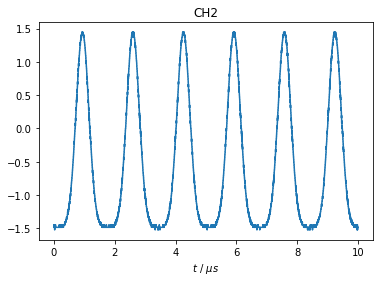

In [9]:
title(param['Source'])
plot(x_axis/1e-6,data)
xlabel(r'$t$ / $\mu s$')

In [12]:
lenght = len(data)
print lenght
import sys
sys.getsizeof(data)

25000


200096

In [14]:
data16 = int16(data)
length16 = len(data16)
print length16
sys.getsizeof(data16)

25000


50096

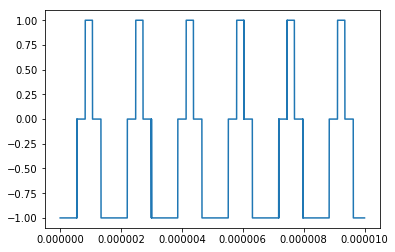

In [17]:
plot(x_axis,data16)

In [39]:
sys.getsizeof(data16)

50096

In [64]:
[j for j in comports()]
port_id = j[0]
with serial.Serial(port_id) as s:
    s.write('*idn?\n')
    result = s.readline()
result

'GW INSTEK,AFG-2225,SN:GEQ904866,V2.05\r\n'

In [46]:
strdata16 = str(data16)
print strdata16

[-1 -1 -1 ..., -1 -1 -1]


In [67]:
with serial.Serial(port_id) as s:
    s.write('SOUR1:DATA:DAC VOLATILE, #550096 '+strdata16+' \n')
    s.write('SOUR1:ARB:OUTP\n')

In [59]:
with serial.Serial(port_id) as s:
    s.write('SOUR1:ARB:OUTP\n')

In [65]:
#OUTPUT TEST WAVE
with serial.Serial(port_id) as s:
    s.write('SOUR1:APPL:SIN 2KHZ,MAX,MAX\n')
    

In [68]:
#RESET INSTRUMENT
with serial.Serial(port_id) as s:
    s.write('*rst\n')

In [ ]:
SOURce[1|2]:DATA:DAC VOLTATILE, #550096 Binary Data